# 신경망 제작

## 신경망 구조

신경망(Neural network)은 신경의 시냅스와 뉴런을 모형으로 한 수학적 모형입니다.

신경망은 총 세 개의 층(layer)을 갖고 있고, 각 층은 뉴런의 집합(또는 배열)으로 이루어져 있습니다.

전체적인 신경망의 구조는 아래와 같습니다.

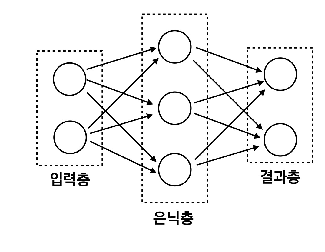

In [6]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('./pic/pic_neural_network.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

### 1. 입력층 (input layer)

입력층은 입력뉴런(input neuron)의 집합입니다. 

입력 뉴런을 통해 신경망 모형을 학습시키거나 결과를 추출합니다.

입력 뉴런을 통해 들어온 신호를 $x_1,\cdots, x_n$라 합시다.

이 신호의 배열 ```X```를 입력층이라 해도 무방합니다.

$$X = \begin{bmatrix} x_1 & \cdots & x_n \end{bmatrix}$$

### 2. 은닉층 (hidden layer)

은닉층은 입력 뉴런을 통해 들어온 신호를 처리하여 얻은 값을 저장하는 중간 뉴런으로 이루어져 있습니다.

은닉층의 $j$번째 뉴런의 값 $y_j$는 다음과 같이 계산됩니다.

$$y_j = x_1W_{1j} + \cdots x_nW_{nj} + b_{j}$$

여기서 $B = \begin{bmatrix} b_1 & \cdots & b_m \end{bmatrix}$는 편향값입니다.

행렬 $W$을 다음과 같이 정의합시다.

$$W = \begin{bmatrix} W_{11} & \cdots & W_{1m} \\
\vdots & \ddots & \vdots \\
W_{n1} & \cdots & W_{nm} \end{bmatrix}$$

배열 $Y = \begin{bmatrix} y_1 & \cdots y_m \end{bmatrix}$은 다음 행렬곱으로 계산됩니다.

$$Y = XW+B$$

참고로 은닉층은 여러개 일 수도 있습니다.

하나의 은닉층 $Y^{(s)}$에서 다음 은닉층 $Y^{(s+1)}$으로 신호를 전달할 때에도 위와 비스산 가중치와 편향을 적용합니다.

$$Y^{(s+1)} = Y^{(s)}W^{(s)}+B^{(s)}$$

참고로 은닉층의 뉴런을 활성화 함수로 전달하여 다음 은닉층으로 넘길 수도 있습니다.

$$Y' = h(Y)$$

활성화 함수에는 이전에 다루었던 계단함수, 시그모이드, ReLU 함수 등을 사용할 수 있습니다.

### 3. 출력층

출력층을 구현하는 것은 은닉층과 유사합니다.

다만 결과물을 분류(classification)할 것이냐 회귀(regression)할 것이냐에 따라 활성화 함수의 사용이 달라집니다.

일반적으로 분류에는 소프트맥스(softmax) 함수를, 회귀에는 항등함수를 사용합니다.

In [10]:
import numpy as np

# 항등 함수를 정의
def ident(x):
    return x 

# 소프트맥스 함수를 정의
def softmax(x):
    ex = np.exp(x)
    return ex / np.sum(ex)

print(softmax([1,2,3,4,5]))
print(softmax([1,2,3,4,50000]))

[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]
[ 0.  0.  0.  0. nan]


C:\Users\hyosa\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


참고로 소프트맥스 함수는 지수연산을 요구합니다.

따라서 입력 배열의 값이 조금이라도 커지면 계산에 오버플로우(overflow, 변수에 할당된 메모리 범위를 넘어서 실제값과 달라지는 경우)가 생길 수 있습니다. 

따라서 아래와 같이 배열의 최댓값이 $1$이 되도록 보정해주는 것이 좋습니다. 

In [11]:
def softmax(x):
    m = np.max(x)
    ex = np.exp(x-m)
    return ex / np.sum(ex)

print(softmax([1,2,3,4,5]))
print(softmax([1,2,3,4,50000]))

[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]
[0. 0. 0. 0. 1.]


# 신경망의 구현

지금까지 정리한 것을 그림으로 나타내면 다음과 같습니다.

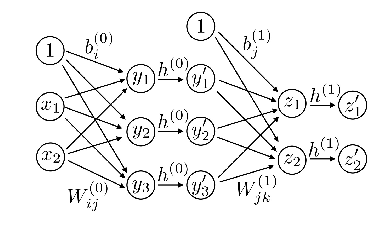

In [16]:
img = imread('./pic/pic_neural_network_with_var.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

이를 토대로 간단한 신경망 모형을 구축해 봅시다.

은닉층의 활성화 함수는 시그모이드 함수로, 출력층의 활성화 함수는 항등 함수라 가정합니다.

가중치 행렬을 아래와 같이 정의합니다.

$$W^{(0)} = \begin{bmatrix} 0.1 & 0.3 & 0.5 \\
    0.2 & 0.4 & 0.6 \end{bmatrix}, W^{(1)} = \begin{bmatrix} 0.1 & 0.2 \\
    0.3 & 0.6 \\
    0.1 & 0.5 \end{bmatrix}$$
    
편향 배열은 아래와 같이 정의합시다.

$$B^{(0)} = \begin{bmatrix} 0.5 & 0.2 & 0.1 \end{bmatrix},B^{(1)} =\begin{bmatrix} 0.2 & 0.3 \end{bmatrix}$$

In [32]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def init_network(): # 뉴럴네트워크를 생성합니다. 가중치와 편향을 정의합니다.
    network = {}
    network['W0'] = np.array([[.1,.3,.5],[.2,.4,.6]])
    network['W1'] = np.array([[.1,.2],[.3,.6],[.1,.5]])
    network['B0'] = np.array([.5,.2,.1])
    network['B1'] = np.array([.2,.3])
    
    return network

def forward(network, X): # 입력값 x를 뉴럴네트워크에 대입하여 결과를 출력합니다.
    W0, W1 = network['W0'], network['W1']
    B0, B1 = network['B0'], network['B1']
    
    Y = np.dot(X,W0) + B0
    Yp = sigmoid(Y)
    Z = np.dot(Yp,W1) + B1
    Zp = ident(Z)
    
    return Zp

network = init_network()
x = np.array([.7,.5])
y = forward(network, x)
print(y)

[0.52845043 1.16065446]


# 데이터셋 준비하기

## MNIST 손글씨 데이터셋

여기에서는 https://github.com/WegraLee/deep-learning-from-scratch 에서 가져온 [mnist.py](./dataset/mnist.py) 파일을 이용합니다.

http://yann.lecun.com/exdb/mnist/ 에는 빅데이터 학습을 위한 손글씨 데이터셋을 제공하고 있습니다. 

이 중에서 아래의 네 개의 파일을 사용합니다.

* train-images-idx3-ubyte.gz : 
    * 손글씨 학습을 위한 이미지 파일입니다. 
    * 흑백으로 구분된 6만개의 28x28사이즈의 이미지 파일이 텍스트로 기록되어 있습니다의
* train-labels-idx1-ubyte.gz :
    * 손글씨 학습 이미지의 숫자값이 기록된 파일입니다.
    * 6만개의 이미지 파일에 대한 숫자 인식 값이 기록되어 있습니다.
* t10k-images-idx3-ubyte.gz : 
    * 학습 검증을 위한 테스트 이미지 파일입니다.
    * 1만개의 28x28사이즈의 이미지 파일이 텍스트로 기록되어 있습니다.
* t10k-labels-idx1-ubyte.gz :
    * 학습 검증을 위한 숫자값이 기록된 파일입니다.
    * 1만개의 이미지 파일에 대한 숫자 인식 값이 기록되어 있습니다.
    
[mnist.py](./dataset/mnist.py)에는 함수 ```load_mnist```가 구현되어 있습니다.

이 함수는 위 네 개의 파일을 인터넷에서 읽어들입니다. (인터넷 연결이 필요합니다)

각 이미지 파일은 784개의 원소로 이루어진 1차원 배열로 변환합니다. (784=28x28이라서 그렇습니다)

아래 코드는 이를 사용한 결과입니다.

In [7]:
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

MNIST에서 불러온 이미지 파일이 잘 저장이 되었는지 확인해 봅시다.

In [13]:
import matplotlib.pyplot as plt
import numpy as np


img = x_train[1]
label = t_train[1]
print(label) # 첫 이미지는 숫자 5입니다.
print(img.shape) # load_mnist는 각 이미지를 1차원 배열로 불러옵니다. 

img = img.reshape(28,28) # 이를 28x28 크기의 2차원 배열로 변환합니다.
plt.imshow(img)
plt.show()

NameError: name 'x_train' is not defined

## (참고) 딕셔너리 자료형

```mnist.py```에서는 데이터를 딕셔너리(dictionary) 형식으로 자료를 저장합니다.

딕셔너리 자료형은 숫자 인덱스 뿐만 아니라 문자 인덱스를 사용하여 여러가지 자료 구조를 한번에 저장할 수 있습니다.

In [11]:
a = {1:'a', 2:'b'}
print(a[1])
b = {'a':1, 'b':2}
print(b['a'])

a
1


딕셔너리 자료는 'key'값으로 구분된 'value'를 저장합니다. 

'key'와 'value'의 순서쌍을 'item'이라 합니다. 

참고로 각 'key'는 모두 달라야 합니다. (사전에 같은 단어가 두 개 등장하면 안되는 것처럼)

In [12]:
A = { 'Mike' : 'A+', 
    'Jane' : 'C-',
    'Alice' : 'B0' }
print(A.keys())
print(A.values())
print(A.items())

grade = A.get('Mike') # 'Mike'라는 이름으로 저장된 값을 불러오기
print(grade)

dict_keys(['Mike', 'Jane', 'Alice'])
dict_values(['A+', 'C-', 'B0'])
dict_items([('Mike', 'A+'), ('Jane', 'C-'), ('Alice', 'B0')])
A+


## (참고) pickle 모듈

파이선의 리스트나 딕셔너리와 같은 변수를 저장하기 위해서 **pickle** 모듈을 사용합니다.

이와 관련된 함수는 _pickle_ 라이브러리에 저장되어 있습니다. 

pickle로 저장된 파일의 확장자는 ```.pkl```입니다.

데이터를 pickle 모듈로 저장하기 위해서는 ```pickle.dump```함수를 사용합니다.

pickle 파일로부터 데이터를 불러오기 위해서는 ```pickle.load```함수를 사용합니다.

위에서 정의한 딕셔너리 변수 ```A```를 pickle 형식으로 저장해 봅시다.

In [13]:
import pickle
with open('./data/test.pkl', 'wb') as f: # "test.pkl"을 쓰기전용(w), 바이트 형식(b)으로 엽니다.
    pickle.dump(A, f)

이를 다시 ```pickle.load```를 사용해서 불러올 수 있습니다.

In [15]:
with open('./data/test.pkl', 'rb') as f:
    B = pickle.load(f)
B.items()

dict_items([('Mike', 'A+'), ('Jane', 'C-'), ('Alice', 'B0')])

# 신경망 예제

이미 만들어진 가중치 행렬로부터 MNIST데이터셋을 분류하고 정확도를 계산해 봅시다. 여기서는 `dataset/`폴더 내의 자료 `sample_weight.pkl`를 이용합니다.

In [36]:
with open("dataset/sample_weight.pkl", "rb") as f:
    network = pickle.load(f)

print(network.keys())

dict_keys(['b2', 'W1', 'b1', 'W2', 'W3', 'b3'])


In [37]:
def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    return x_test, t_test

def init_network():
    with open("dataset/sample_weight.pkl", "rb") as f:
        network = pickle.load(f)
    return network

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    B1, B2, B3 = network['b1'], network['b2'], network['b3']
    
    A1 = np.dot(x, W1) + B1
    Z1 = sigmoid(A1)
    A2 = np.dot(Z1, W2) + B2
    Z2 = sigmoid(A2)
    A3 = np.dot(Z2, W3) + B3
    Y = softmax(A3)
    
    return Y

In [39]:
x, t = get_data()
network = init_network()

print(network.keys())

accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i])
    p = np.argmax(y)
    if p == t[i]:
        accuracy_cnt += 1

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

dict_keys(['b2', 'W1', 'b1', 'W2', 'W3', 'b3'])
Accuracy:0.9352


In [44]:
print(x.shape)
print(x[0].shape)
W1, W2, W3 = network['W1'], network['W2'], network['W3']
print(W1.shape)
print(W2.shape)
print(W3.shape)

(10000, 784)
(784,)
(784, 50)
(50, 100)
(100, 10)


테스트 데이터의 총 갯수는 1만개이고, 각 데이터는 784개의 요소, 즉 784차원 벡터로 구성되어 있습니다. (참고로 28x28= 734입니다.) 첫번째 가중치 행렬은 784행 50열로 구성되어 있습니다. 즉, 1층 뉴런의 갯수는 총 50개입니다. 두번째 가중치 행렬은 50행 100열입니다. 즉, 2층 뉴런의 갯수는 100개 입니다. 마지막 세번째 가중치 행렬은 100행 10열 입니다. 즉, 마지막 출력 뉴런의 갯수는 10개입니다. 이 중에서 가장 큰 값을 가진 뉴런이 (확률적으로) 정답이 됩니다.